In [367]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import gpytorch
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error



os.environ["OMP_NUM_THREADS"] = "2"



def data_import(path1, delimiter):
    #locate file path and import data
    if delimiter == 'none':
        file1 = pd.read_csv(path1)
    else:   
        file1 = pd.read_csv(path1, delimiter=delimiter)
    return file1

def data_convert(file1, time_column_name: str):
    #convert timestamps to datetime format
    file1[time_column_name] = pd.to_datetime(file1[time_column_name])
    return file1


#function to remove any rows containing even a single NaN value
def remove_nan(df):
    df = df.replace("nan", np.nan)
    df = df.dropna()
    return df

def data_frequency(file1, desired_frequency: str, time_column_name: str):
    if desired_frequency == 'ten_minute':
        file1 = file1.resample('10T', on=time_column_name).mean()
    elif desired_frequency == '4_hourly':
        file1 = file1.resample('4h', on=time_column_name).mean()
    elif desired_frequency == 'hourly':
        file1 = file1.resample('h', on=time_column_name).mean()
    elif desired_frequency == 'twelve_hourly':
        file1 = file1.resample('12h', on=time_column_name).mean()
    elif desired_frequency == 'daily':
        file1 = file1.resample('D', on=time_column_name).mean()

    # Ensure the index is datetime
    file1.index = pd.to_datetime(file1.index)
    
    # Reset the index and name it 'Time(UTC)'
    file1.reset_index(inplace=True)
    file1.rename(columns={file1.index.name: time_column_name}, inplace=True)

    return file1


def time_to_sincos(df):
    sin_values = []
    cos_values = []

    for i in range(len(df)):
        sin_values.append(np.sin((2 * np.pi * i) / 365.25))
        cos_values.append(np.cos((2 * np.pi * i) / 365.25))
        
    df['Time_sin'] = sin_values
    df['Time_cos'] = cos_values
    
    return df

#trim data to desired collumns
def file_trim(file1, desired_collumns):
    file1 = file1[desired_collumns]
    return file1

#separate data by seasons
def data_split(file1, time_column_name: str):
    winter = file1[(file1[time_column_name] >= '2022-12-21') & (file1[time_column_name] < '2023-03-20')]
    spring = file1[(file1[time_column_name] >= '2023-03-20') & (file1[time_column_name] < '2023-06-21')]
    summer = file1[(file1[time_column_name] >= '2022-06-21') & (file1[time_column_name] < '2022-09-23')]
    autunm = file1[(file1[time_column_name] >= '2022-09-23') & (file1[time_column_name] < '2022-12-21')]
    return winter, spring, summer, autunm





In [ ]:
#importing s2 and m1 data sets
s2_site_data= data_import("C:\\Users\\396760\\lanl\\data\\ARMSAILS2_cleaned.csv", 'none')
m1_site_data = data_import("C:\\Users\\396760\\lanl\\data\\ARMSAILM1_cleaned.csv", 'none')

#data conversion and handling for m1, s2 data
s2_site_data, m1_site_data = data_convert(s2_site_data, 'Time(UTC)'), data_convert(m1_site_data, 'Time(UTC)')

#defining collumns and imp feature variables
collumns = ['Time(UTC)', 'sample_rh_pct', 'sample_temp_C', 'pm_1_ug_per_m3', 'Time_sin', 'Time_cos']
collumns1 = ['Time(UTC)', 'sample_rh_pct', 'sample_temp_C', 'pm_25_ug_per_m3', 'Time_sin', 'Time_cos']
features = ['sample_rh_pct', 'sample_temp_C', 'Time_sin', 'Time_cos']
s2_target_pm1 = m1_target_pm1 = ['pm_1_ug_per_m3']
s2_target_pm25 = m1_target_pm25 = ['pm_25_ug_per_m3']
s2_target_pm10 = m1_target_pm10 = ['pm_10_ug_per_m3']

In [ ]:
#defining datasets of differing frequencies in the following order : daily, 12 hourly, 4 hourly and hourly, 
s2_site_daily, m1_site_daily = data_frequency(s2_site_data, 'daily', 'Time(UTC)'), data_frequency(m1_site_data, 'daily', 'Time(UTC)')
s2_site_12hourly, m1_site_12hourly = data_frequency(s2_site_data, 'twelve_hourly', 'Time(UTC)'), data_frequency(m1_site_data, 'twelve_hourly', 'Time(UTC)')
s2_site_4hourly, m1_site_4hourly = data_frequency(s2_site_data, '4_hourly', 'Time(UTC)'), data_frequency(m1_site_data, '4_hourly', 'Time(UTC)')
s2_site_hourly, m1_site_hourly = data_frequency(s2_site_data, 'hourly', 'Time(UTC)'), data_frequency(m1_site_data, 'hourly', 'Time(UTC)')

#time to sin cos conversion
s2_site_daily, m1_site_daily = time_to_sincos(s2_site_daily), time_to_sincos(m1_site_daily)
s2_site_12hourly, m1_site_12hourly = time_to_sincos(s2_site_12hourly), time_to_sincos(m1_site_12hourly)
s2_site_4hourly, m1_site_4hourly = time_to_sincos(s2_site_4hourly), time_to_sincos(m1_site_4hourly)
s2_site_hourly, m1_site_hourly = time_to_sincos(s2_site_hourly), time_to_sincos(m1_site_hourly)

#dropping rows with nan values
s2_site_daily, m1_site_daily = remove_nan(s2_site_daily), remove_nan(m1_site_daily)
s2_site_12hourly, m1_site_12hourly = remove_nan(s2_site_12hourly), remove_nan(m1_site_12hourly)
s2_site_4hourly, m1_site_4hourly = remove_nan(s2_site_4hourly), remove_nan(m1_site_4hourly)
s2_site_hourly, m1_site_hourly = remove_nan(s2_site_hourly), remove_nan(m1_site_hourly)


#splitting data by seasons

#daily
s2_winter_daily, s2_spring_daily, s2_summer_daily, s2_autunm_daily = data_split(s2_site_daily, 'Time(UTC)')
m1_winter_daily, m1_spring_daily, m1_summer_daily, m1_autunm_daily = data_split(m1_site_daily, 'Time(UTC)')
#12 hourly
s2_winter_12hourly, s2_spring_12hourly, s2_summer_12hourly, s2_autunm_12hourly = data_split(s2_site_12hourly, 'Time(UTC)')
m1_winter_12hourly, m1_spring_12hourly, m1_summer_12hourly, m1_autunm_12hourly = data_split(m1_site_12hourly, 'Time(UTC)')
#4 hourly
s2_winter_4hourly, s2_spring_4hourly, s2_summer_4hourly, s2_autunm_4hourly = data_split(s2_site_4hourly, 'Time(UTC)')
m1_winter_4hourly, m1_spring_4hourly, m1_summer_4hourly, m1_autunm_4hourly = data_split(m1_site_4hourly, 'Time(UTC)')
#hourly
s2_winter_hourly, s2_spring_hourly, s2_summer_hourly, s2_autunm_hourly = data_split(s2_site_hourly, 'Time(UTC)')
m1_winter_hourly, m1_spring_hourly, m1_summer_hourly, m1_autunm_hourly = data_split(m1_site_hourly, 'Time(UTC)')

#plots for s2 data sites at varying frequencies (PM1)

#daily
plt.figure(figsize=(10,5))
plt.plot(s2_winter_daily['Time(UTC)'], s2_winter_daily['pm_1_ug_per_m3'], label='Winter')
plt.plot(s2_spring_daily['Time(UTC)'], s2_spring_daily['pm_1_ug_per_m3'], label='Spring')
plt.plot(s2_summer_daily['Time(UTC)'], s2_summer_daily['pm_1_ug_per_m3'], label='Summer')
plt.plot(s2_autunm_daily['Time(UTC)'], s2_autunm_daily['pm_1_ug_per_m3'], label='Autunm')
plt.legend()
plt.show()

#12 hourly
plt.figure(figsize=(10,5))
plt.plot(s2_winter_12hourly['Time(UTC)'], s2_winter_12hourly['pm_1_ug_per_m3'], label='Winter')
plt.plot(s2_spring_12hourly['Time(UTC)'], s2_spring_12hourly['pm_1_ug_per_m3'], label='Spring')
plt.plot(s2_summer_12hourly['Time(UTC)'], s2_summer_12hourly['pm_1_ug_per_m3'], label='Summer')
plt.plot(s2_autunm_12hourly['Time(UTC)'], s2_autunm_12hourly['pm_1_ug_per_m3'], label='Autunm')
plt.legend()
plt.show()

#4 hourly
plt.figure(figsize=(10,5))
plt.plot(s2_winter_4hourly['Time(UTC)'], s2_winter_4hourly['pm_1_ug_per_m3'], label='Winter')
plt.plot(s2_spring_4hourly['Time(UTC)'], s2_spring_4hourly['pm_1_ug_per_m3'], label='Spring')
plt.plot(s2_summer_4hourly['Time(UTC)'], s2_summer_4hourly['pm_1_ug_per_m3'], label='Summer')
plt.plot(s2_autunm_4hourly['Time(UTC)'], s2_autunm_4hourly['pm_1_ug_per_m3'], label='Autunm')
plt.legend()
plt.show()

#hourly
plt.figure(figsize=(10,5))
plt.plot(s2_winter_hourly['Time(UTC)'], s2_winter_hourly['pm_1_ug_per_m3'], label='Winter')
plt.plot(s2_spring_hourly['Time(UTC)'], s2_spring_hourly['pm_1_ug_per_m3'], label='Spring')
plt.plot(s2_summer_hourly['Time(UTC)'], s2_summer_hourly['pm_1_ug_per_m3'], label='Summer')
plt.plot(s2_autunm_hourly['Time(UTC)'], s2_autunm_hourly['pm_1_ug_per_m3'], label='Autunm')
plt.legend()
plt.show()


In [368]:
def extract_subset(X, y):
    # Number of points for training
    n = len(X)//3
    # Randomly shuffle the data
    indices = np.random.permutation(len(X))
    # Select training and testing indices
    train_indices = indices[:n]
    test_indices = indices[n:]
    # Split the data into training and testing sets
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test, train_indices, test_indices



# Function to scale the data
def scale_data(X_train, X_test, y_train, y_test):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    # Fit the scaler on the training targets and transform both training and testing targets
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y

#function to conver to torch tensors
def to_tensor(x_train, x_test, y_train, y_test):
    x_train, x_test = torch.tensor(x_train, dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
    # Squeeze to ensure correct dimensions
    if y_train.dim() > 1:
        y_train = y_train.squeeze(1)
    if y_test.dim() > 1:
        y_test = y_test.squeeze(1)
    return x_train, x_test, y_train, y_test




In [424]:

# Define the ExactGPModel class
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Function to train the GP model
def train_gp_model(x_train, y_train, training_iter=50, lr=0.1, set_low_noise=False):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(x_train, y_train, likelihood)

    # Train the model
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    losses = []

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(x_train)
        loss = -mll(output, y_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        """ if i % 2 == 0:
            print(f'Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} '
                  f'squared lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f} '
                  f'noise variance: {model.likelihood.noise.item():.3f}')
     """
    # Print the noise variance after training
    print(f'Final noise variance: {model.likelihood.noise.item():.3f}')
    return model, likelihood, losses

# Function to make predictions
def predict_gp_model(model, likelihood, x_test):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_test))
    return observed_pred

def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def plot_gp_results(x_train_time, y_train, x_test_time, y_test, observed_pred, season, title='Gaussian Process Regression'):

    fig, ax = plt.subplots(figsize=(14, 7))

    # Sort the indices to ensure proper alignment
    sorted_train_indices = np.argsort(x_train_time.values)
    sorted_test_indices = np.argsort(x_test_time.values)

    # Plot training data
    ax.plot(x_train_time.values[sorted_train_indices], y_train.numpy()[sorted_train_indices], 'k*', label='Train data')

    # Plot test data
    ax.plot(x_test_time.values[sorted_test_indices], y_test.numpy()[sorted_test_indices], 'b*', label='Test data')
    
    #plot the true function

    
    # Plot predicted mean and confidence intervals
    ax.plot(x_test_time.values[sorted_test_indices], observed_pred.mean.numpy()[sorted_test_indices], 'r', label='Predicted mean')
    lower, upper = observed_pred.confidence_region()
    ax.fill_between(x_test_time.values[sorted_test_indices], lower.numpy()[sorted_test_indices], upper.numpy()[sorted_test_indices], alpha=0.5, label='Confidence interval')

    

    # Set labels and title
    ax.set_xlabel('Time(UTC)')
    ax.set_ylabel('PM 1.0 Concentration (ug/m3)')
    rmse = calculate_rmse(y_test.numpy(), observed_pred.mean.numpy())
    ax.set_title(f'{title} - {season}\nRMSE: {rmse:.3f}')
    ax.legend()

    plt.show()

# General function to run the GP pipeline
def run_gp_pipeline(x_train, y_train, x_test, y_test, x_train_time, x_test_time, season, training_iter=50, lr=0.1):
    model, likelihood, losses = train_gp_model(x_train, y_train, training_iter, lr)
    observed_pred = predict_gp_model(model, likelihood, x_test)
    plot_gp_results(x_train_time, y_train, x_test_time, y_test, observed_pred, season)
    return model, likelihood, losses, observed_pred


Final noise variance: 2.974


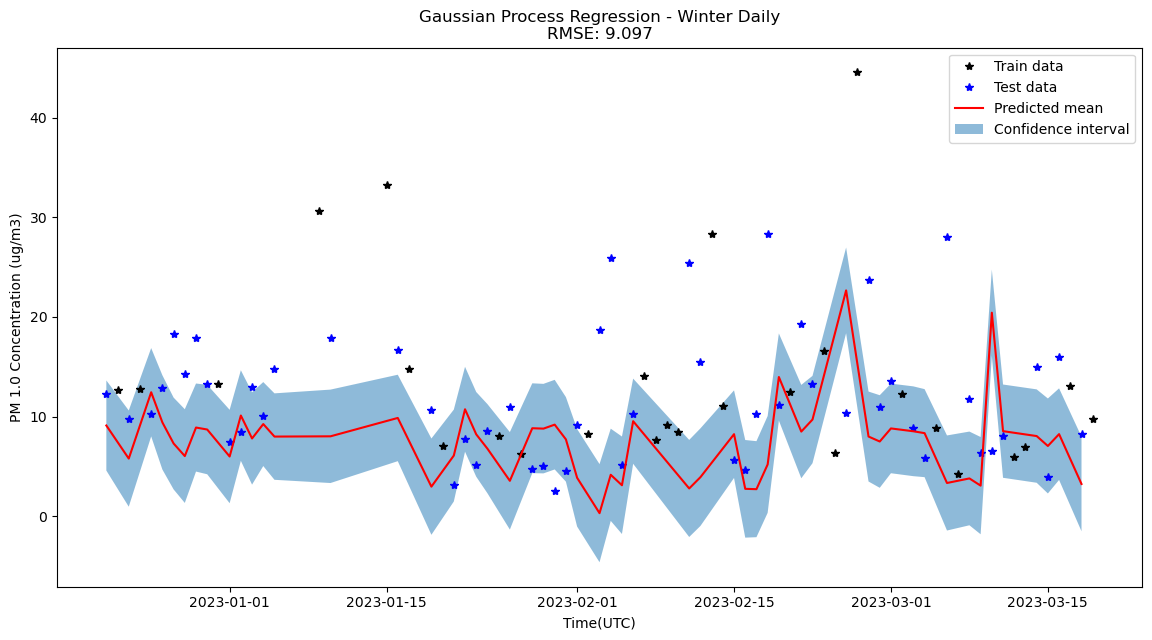

In [423]:

# Extracting the subset of data for training and testing
x_train_windaily, x_test_windaily, y_train_windaily, y_test_windaily, train_indices, test_indices = extract_subset(s2_winter_daily[features].values, 
                                                                                                                   s2_winter_daily[s2_target_pm1].values)

# Convert to torch tensors
x_train_windaily, x_test_windaily, y_train_windaily, y_test_windaily = to_tensor(x_train_windaily, x_test_windaily,
                                                                                 y_train_windaily, y_test_windaily)

# Get corresponding time indices for training and testing
x_train_time = s2_winter_daily['Time(UTC)'].iloc[train_indices]
x_test_time = s2_winter_daily['Time(UTC)'].iloc[test_indices]

# Run GP pipeline with season name
season = 'Winter Daily'
model, likelihood, losses, observed_pred = run_gp_pipeline(x_train_windaily, y_train_windaily, x_test_windaily, y_test_windaily,
                                                           x_train_time, x_test_time, season)